# Домашнее задание к занятию "Тематическое моделирование"

### Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.
Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.
Тексты хранятся в json-ах в массиве responses.
Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

In [1]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [33]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [92]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
from pymystem3 import Mystem
mystem = Mystem()

In [292]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics  import classification_report

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MYSELF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
responses = []
with bz2.BZ2File('D:/DATA_SCIENCE/dataset/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:49, 1186.38it/s]


In [8]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [9]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


#### Часть 1. Анализ текстов

* Посчитайте количество отзывов в разных городах и на разные банки

In [11]:
df.groupby(df.city)['title'].count()

city
г.  (Красногорск)                           1
г.  (Москва)                                2
г.  (Россия)                                1
г.  (Ханты-Мансийский автономный округ)     1
г. -                                        1
                                           ..
г. ялуторовск                               1
г. янаул                                    2
г. ярославль                               12
г. ярцево                                   2
г. … или другой населенный пункт            1
Name: title, Length: 5823, dtype: int64

In [12]:
df.groupby(df.bank_name)['title'].count()

bank_name
2Т Банк          655
АБ Финанс         23
АББ                2
АМБ Банк           1
АМТ Банк         142
                ... 
Юнистрим          81
ЯР-Банк           12
Яндекс.Деньги    226
Ярославич          5
Ярсоцбанк          7
Name: title, Length: 670, dtype: int64

* Постройте гистограмы длин текстов в символах и в словах

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
vec_words = CountVectorizer(ngram_range=(1, 1), stop_words=stopwords.words('russian'))
bow_words = vec_words.fit_transform(df.text)
vec_symbol = CountVectorizer(analyzer='char')
bow_symbol = vec_symbol.fit_transform(df.text)

In [15]:
ln_words = []
ln_symbol = []
for i in range(1000):
    ln_words.append(np.sum(bow_words[i].todense()))
    ln_symbol.append(np.sum(bow_symbol[i].todense()))

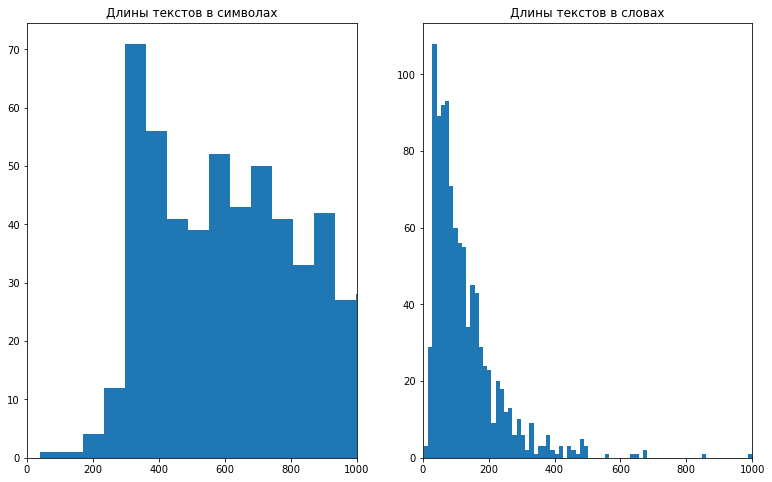

In [16]:
fig, axes = plt.subplots(1, 2,figsize=(13,8))

axes[0].hist(ln_symbol, bins = 200)
axes[0].set_xlim(0, 1000)
axes[1].hist(ln_words, bins = 100)
axes[1].set_xlim(0, 1000)
axes[0].set_title(u"Длины текстов в символах")
axes[1].set_title(u"Длины текстов в словах")
fig.show()

* Найдите 10 самых частых:
  * слов
  * слов без стоп-слов
  * лемм
  * существительных

In [17]:
# слов
sorted(list(zip(vec_words.vocabulary_.keys(), bow_words.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

[('спрашивающего', 275765),
 ('погуглила', 215209),
 ('пащинская', 183365),
 ('нескончаемыми', 131197),
 ('1067184', 105824),
 ('гренбери', 101814),
 ('староневский', 81116),
 ('32541', 76546),
 ('буфеты', 72085),
 ('радикальных', 70422)]

In [18]:
# слов без стоп-слов
vec = CountVectorizer(ngram_range=(1, 1), stop_words=None)
bow = vec.fit_transform(df.text)
sorted(list(zip(vec.vocabulary_.keys(), bow.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

[('отвечавшая', 852416),
 ('табак', 707784),
 ('выдворят', 640053),
 ('вызови', 372738),
 ('отличавшееся', 320956),
 ('вежливами', 275765),
 ('радыгин', 215209),
 ('устраивался', 205679),
 ('352501001', 200416),
 ('walk', 192847)]

In [20]:
df = df.dropna()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74710 entries, 14 to 138946
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                74710 non-null  object 
 1   rating_not_checked  74710 non-null  bool   
 2   title               74710 non-null  object 
 3   num_comments        74710 non-null  int64  
 4   bank_license        74710 non-null  object 
 5   author              74710 non-null  object 
 6   bank_name           74710 non-null  object 
 7   datetime            74710 non-null  object 
 8   text                74710 non-null  object 
 9   rating_grade        74710 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 5.8+ MB


In [ ]:
Y = df.rating_grade

In [31]:
X = df.drop('rating_grade', axis=1)

(74710, 9)

In [34]:
# С целью уменьшения нагрузки на процессор сделаем выборку из датасета
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.05, random_state=42, stratify = Y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3735, 9), (70975, 9), (3735,), (70975,))

In [35]:
X = X_train
Y = y_train

In [44]:
# лемм
lemmas1 = [morph.parse(word)[0].normal_form for word in X.text.to_string().lower().split()]
vec_lemm = CountVectorizer(ngram_range=(1, 1), stop_words=stopwords.words('russian'))
bow_lemm = vec_lemm.fit_transform(lemmas1)
sorted(list(zip(vec_lemm.vocabulary_.keys(), bow_lemm.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

[('автокопилка', 718),
 ('116511', 424),
 ('129684', 379),
 ('137025', 362),
 ('медиамаркт', 291),
 ('114178', 288),
 ('мос', 250),
 ('навязчивый', 201),
 ('сайту', 198),
 ('специал', 185)]

In [88]:
# существительных
 
noun = [word for word in lemmas1 if morph.parse(word)[0].tag.POS=='NOUN' ]
noun
vec_noun = CountVectorizer(ngram_range=(1, 1))
bow_noun = vec_noun.fit_transform(noun)
sorted(list(zip(vec_noun.vocabulary_.keys(), bow_noun.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

[('качество', 634),
 ('акб', 347),
 ('операционист', 287),
 ('мини', 243),
 ('рублёв', 141),
 ('трубка', 138),
 ('оплата', 131),
 ('общественность', 94),
 ('жалоба', 88),
 ('форумчанин', 85)]

* Постройте кривые Ципфа и Хипса

In [90]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [93]:
from collections import Counter
corpus = [token for tweet in X.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

1033425


['Здравствуйте',
 'Очень',
 'хочется',
 'выразить',
 'благодарность',
 'руководителю',
 'Ал-ной',
 'Л.С',
 'отделения',
 'Сбербанка']

In [96]:
freq_dict = Counter(corpus)

# freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
freq_dict.most_common(10)

[('в', 32932),
 ('и', 28122),
 ('не', 22896),
 ('на', 17667),
 ('что', 17530),
 ('я', 12539),
 ('с', 12020),
 ('по', 9354),
 ('мне', 8515),
 ('банка', 6631)]

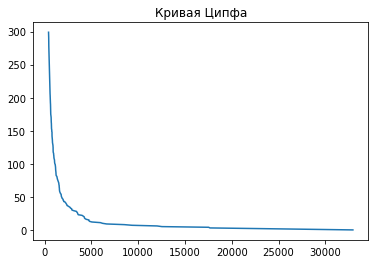

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
ax.set_title(u'Кривая Ципфа', fontsize=12)
plt.show()

In [130]:
from tqdm import tqdm

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(X.iterrows(), total = len(X)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|██████████| 3735/3735 [00:44<00:00, 84.36it/s] 


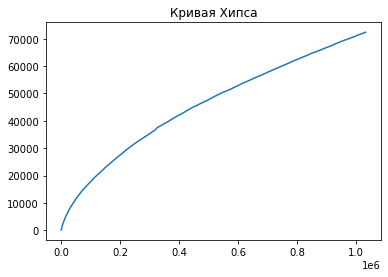

In [131]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
ax.set_title(u'Кривая Хипса', fontsize=12)
plt.show()

* Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [155]:
for  i in ["сотрудник", "клиент", "мошенничество", "доверие"]:
    print(i, freq_dict.get(i))

сотрудник 744
клиент 405
мошенничество 19
доверие 27


* В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5.
Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов
(с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [159]:
pos = df.loc[df.rating_grade==5]
neg = df.loc[df.rating_grade==1]

In [178]:
vec = TfidfVectorizer(ngram_range=(1, 1), stop_words=stopwords.words('russian'))
bow = vec.fit(df.title)

In [179]:
print('Ключевые слова для положительных отзывов')
bow_pos = bow.transform(pos.title)
sorted(list(zip(vec.vocabulary_.keys(), bow_pos.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

Ключевые слова для положительных отзывов


[('проблемами', 395.40761430558575),
 ('теряет', 368.233497444977),
 ('59р', 321.3188033696577),
 ('вынуждающее', 251.51163214893674),
 ('вину', 184.50265894687792),
 ('рассрочкой', 130.49433088983287),
 ('горькое', 105.3107339908883),
 ('строить', 104.89816666316145),
 ('начхать', 102.70455261485913),
 ('принесет', 99.939706225379)]

In [180]:
print('Ключевые слова для отрицательных отзывов')
bow_neg = bow.transform(neg.title)
sorted(list(zip(vec.vocabulary_.keys(), bow_neg.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

Ключевые слова для отрицательных отзывов


[('недобросовестный', 959.9768563602177),
 ('проблемами', 852.6879745027343),
 ('рассрочкой', 708.3132166096443),
 ('великолепно', 523.7249093600086),
 ('вынуждающее', 498.2691170039271),
 ('людям', 480.92799949253595),
 ('человеком', 402.80934368368474),
 ('пределе', 375.33057133743904),
 ('среднем', 369.4893102100691),
 ('побывать', 357.67534090534133)]

In [181]:
vec = TfidfVectorizer(ngram_range=(2, 2), stop_words=stopwords.words('russian'))
bow = vec.fit(df.title)

In [182]:
print('Биграммы для положительных отзывов')
bow_pos = bow.transform(pos.title)
sorted(list(zip(vec.vocabulary_.keys(), bow_pos.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

Биграммы для положительных отзывов


[('сюрприз хоума', 145.05761154080105),
 ('деньги те', 84.66114249317523),
 ('ижевске понравилось', 72.64409162293431),
 ('зависло зависло', 62.243840246095445),
 ('сотрудники дилетанты', 51.27494515467641),
 ('руб акции', 46.208923944103425),
 ('списанные средства', 43.00136248829607),
 ('добиться регулярного', 42.199609721699694),
 ('могу добиться', 36.86302736821293),
 ('банке закрытии', 35.291973612743945)]

In [183]:
print('Биграммы для отрицательных отзывов')
bow_neg = bow.transform(neg.title)
sorted(list(zip(vec.vocabulary_.keys(), bow_neg.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

Биграммы для отрицательных отзывов


[('банка рс', 178.33602333094484),
 ('полезности бесцельных', 175.6623771811733),
 ('банк выполнять', 160.2605832228851),
 ('перевод ленинском', 142.83035875679047),
 ('выдали денежные', 132.6915789856816),
 ('телефон бесконечные', 125.08112310306095),
 ('заботится сохранении', 120.90813498566939),
 ('воза упало', 116.6920572966939),
 ('сергея николаевича', 112.69620579659352),
 ('услуга процентов', 109.23015667744804)]

#### Часть 2. Тематическое моделирование
* Постройте несколько тематических моделей коллекции документов с разным числом тем.
* Приведите примеры понятных (интерпретируемых) тем.
* Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк).
* Можете ли вы их прокомментировать / объяснить?
* Эта часть задания может быть сделана с использованием gensim.

In [177]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [187]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmat(text):   
    try:
        return " ".join([morph.parse(word)[0].normal_form for word in text.split()]).strip()
    except:
        return ""

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmat(words_only(text.lower())))

In [188]:
text = X.text.apply(preprocess)
text

69597     здравствуйте очень хотеться выразить благодарн...
52111     год назад стать обладатель зарплатный карта ба...
20142     сегодня приша л отделение мир м рижский получи...
11829     февраль терминал оао мкб внести деньга счёт кр...
134821    хотеть выступить защита банк обслуживание хоро...
                                ...                        
55923     просто издевательски относиться газпромбанк мо...
52520     год взять банк хоум кредит адрес г нижний новг...
87835     делать вклад время деньга понедельник март ули...
118639    решить толком провести выделить минута свободн...
70971     добрый день пользоваться услуга банк год принц...
Name: text, Length: 3735, dtype: object

In [ ]:
texts = [text1.split() for text1 in text]

In [192]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [193]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [194]:
corpus_tfidf

In [195]:
# %%time
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [196]:
len(corpus)

3735

In [197]:
sims[0]

array([0.9999999 , 0.03438673, 0.02418807, ..., 0.00441715, 0.01904603,
       0.02825274], dtype=float32)

In [198]:
sims.shape

(3735, 3735)

In [201]:
from gensim.models import lsimodel

In [206]:
# 5 тем
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

In [207]:
lsi.show_topics(5)

[(0,
  '0.197*"карта" + 0.138*"кредит" + 0.116*"вклад" + 0.112*"банкомат" + 0.111*"деньга" + 0.111*"заявление" + 0.106*"счёт" + 0.099*"отделение" + 0.096*"сбербанк" + 0.093*"сумма"'),
 (1,
  '0.556*"вклад" + -0.285*"кредит" + -0.160*"платёж" + -0.150*"страховка" + 0.148*"очередь" + -0.144*"погашение" + 0.128*"открыть" + -0.120*"задолженность" + -0.106*"заявление" + 0.104*"касса"'),
 (2,
  '-0.402*"банкомат" + 0.330*"кредит" + -0.247*"карта" + 0.231*"вклад" + 0.205*"страховка" + -0.162*"сбербанк" + 0.151*"договор" + -0.150*"деньга" + -0.131*"операция" + 0.115*"документ"'),
 (3,
  '-0.349*"банкомат" + -0.316*"вклад" + 0.311*"карта" + 0.176*"заявка" + -0.164*"сумма" + -0.159*"деньга" + -0.122*"платёж" + -0.119*"погашение" + -0.116*"кредит" + -0.111*"средство"'),
 (4,
  '-0.422*"банкомат" + 0.290*"вклад" + 0.217*"карта" + -0.159*"заявка" + -0.144*"кредит" + 0.138*"счёт" + 0.134*"задолженность" + -0.134*"очередь" + 0.115*"средство" + -0.111*"купюра"')]

In [213]:
# 30 тем
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

In [214]:
lsi.show_topics(5)

[(0,
  '0.197*"карта" + 0.138*"кредит" + 0.116*"вклад" + 0.112*"банкомат" + 0.111*"деньга" + 0.111*"заявление" + 0.106*"счёт" + 0.099*"отделение" + 0.096*"сбербанк" + 0.093*"сумма"'),
 (1,
  '0.556*"вклад" + -0.285*"кредит" + -0.159*"платёж" + -0.150*"страховка" + 0.148*"очередь" + -0.145*"погашение" + 0.128*"открыть" + -0.121*"задолженность" + -0.106*"заявление" + 0.103*"касса"'),
 (2,
  '-0.402*"банкомат" + 0.329*"кредит" + -0.246*"карта" + 0.231*"вклад" + 0.205*"страховка" + -0.161*"сбербанк" + 0.151*"договор" + -0.150*"деньга" + -0.131*"операция" + 0.115*"документ"'),
 (3,
  '-0.347*"банкомат" + -0.316*"вклад" + 0.312*"карта" + 0.176*"заявка" + -0.164*"сумма" + -0.158*"деньга" + -0.122*"платёж" + -0.118*"погашение" + -0.116*"кредит" + -0.113*"средство"'),
 (4,
  '-0.422*"банкомат" + 0.291*"вклад" + 0.217*"карта" + -0.160*"заявка" + -0.143*"кредит" + 0.137*"счёт" + 0.133*"задолженность" + -0.131*"очередь" + 0.114*"средство" + -0.112*"купюра"')]

##### Понятные темы: карта, кредит, вклад, банкомат

In [249]:
for i in range(30):    
    for j in lsi.show_topic(topicno=i, topn=10):
        if j[0] in ['сбербанк', 'альфа', 'втб']:
            print('topic =', i, j)

topic = 0 ('сбербанк', 0.09623265225201241)
topic = 2 ('сбербанк', -0.1612483171922016)
topic = 5 ('сбербанк', -0.22609427887314837)
topic = 7 ('сбербанк', 0.2451094060657448)
topic = 8 ('сбербанк', 0.3184233940519557)
topic = 10 ('сбербанк', 0.21157122486291544)
topic = 10 ('альфа', -0.12094625640492163)
topic = 11 ('сбербанк', -0.3579407518369578)
topic = 12 ('сбербанк', 0.13783598696790303)
topic = 13 ('сбербанк', 0.23308232911409218)
topic = 13 ('альфа', 0.16461503476790798)
topic = 14 ('сбербанк', -0.14904298309237152)
topic = 15 ('альфа', -0.18461890775435816)
topic = 16 ('сбербанк', -0.1384911554999508)
topic = 21 ('альфа', -0.31474180177585304)
topic = 22 ('альфа', 0.41442105470661533)
topic = 22 ('втб', -0.12200824382426935)
topic = 24 ('альфа', -0.24097016425647566)
topic = 24 ('втб', -0.15195590787411303)
topic = 25 ('альфа', -0.2014380476894226)
topic = 28 ('альфа', -0.17996106585074192)
topic = 29 ('сбербанк', -0.11913214474344282)


#### Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: 
будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1)
и положительные отзывы (с оценкой 5).

* Составьте обучающее и тестовое множество: 
    **выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение).

In [264]:
data = pd.concat([pos.iloc[:3000], neg.iloc[:3000]])

* Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [267]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.rating_grade, train_size=0.7, random_state=42, stratify = data.rating_grade)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4200,), (1800,), (4200,), (1800,))

In [269]:
X_train = X_train.apply(preprocess)
X_train

26854    покупка машина потребоваться доплата принцип н...
3318     декабрь заблокировать карта написать заявление...
585      здравствуйте сразу написать являться клиент ба...
10647    обслуживание сбербанк бум переров корпус рядом...
10814    здравствуйте способ вывод карта информация пла...
                               ...                        
33222    узнать банк случайно поездка прага решить запа...
6616     являться клиент банк год никакой проблема всё ...
3299     март месяц день получить зарплатный карточка с...
7463     добрый день лебедев владимир являться х год за...
5602     добрый день декабрь год оформить ипотечный кре...
Name: text, Length: 4200, dtype: object

In [270]:
X_test = X_test.apply(preprocess)
X_test

8619     хотеть поблагодарить сотрудник отдел претензио...
4672     очень сильно мешать жить постоянный звонок соо...
2144     год назад жена сделать вклад ваш банк примерно...
5546     снимать деньга банкомат банкомат списать деньг...
9623     март г организация подать исполнительный лист ...
                               ...                        
31492    добрый день обычно отзыв читать решить написат...
45281    вообще ткс банк виртуальный поддержка должный ...
4810     добрый день март год адрес путём почтовый отпр...
43653    перевести телефон рубль пользоваться очень нес...
9997     добрый день май оформить кредит телефон связны...
Name: text, Length: 1800, dtype: object

* Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline.
* Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
* Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
     * 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
     * 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). 
Используйте accuracy и F-measure для оценки качества классификации.
В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [280]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [295]:
# 1-вариант: 𝑡𝑓−𝑖𝑑𝑓  преобразование  и сингулярное разложение
dic = [((1, 1)), ((2, 2)), ((3, 3))]
for i in dic:
    clf = Pipeline([ 
        ('vect', CountVectorizer(ngram_range=i)), 
        ('tfidf', TfidfTransformer()), 
        ('tm', TruncatedSVD()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=2, random_state=0))
    ])
    clf.fit(X_train, y_train)  
    pred = clf.predict(X_test)
    print(classification_report(pred, y_test))
    print('____________________________________')
clf = Pipeline([ 
        ('vect', CountVectorizer(analyzer='char')), 
        ('tfidf', TfidfTransformer()), 
        ('tm', TruncatedSVD()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=3, random_state=0))
    ])
clf.fit(X_train, y_train)  
pred = clf.predict(X_test)
print(classification_report(pred, y_test))    

              precision    recall  f1-score   support

         1.0       0.82      0.76      0.79       971
         5.0       0.74      0.80      0.77       829

    accuracy                           0.78      1800
   macro avg       0.78      0.78      0.78      1800
weighted avg       0.78      0.78      0.78      1800

____________________________________
              precision    recall  f1-score   support

         1.0       0.80      0.82      0.81       871
         5.0       0.83      0.80      0.82       929

    accuracy                           0.81      1800
   macro avg       0.81      0.81      0.81      1800
weighted avg       0.81      0.81      0.81      1800

____________________________________
              precision    recall  f1-score   support

         1.0       0.83      0.54      0.66      1379
         5.0       0.30      0.64      0.41       421

    accuracy                           0.57      1800
   macro avg       0.57      0.59      0.53      1800


##### Лучшая оценка на биграммах

In [294]:
# 2-й вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation)
dic = [((1, 1)), ((2, 2)), ((3, 3))]
for i in dic:
    clf = Pipeline([ 
        ('vect', CountVectorizer(ngram_range=i)), 
        ('tfidf', TfidfTransformer()), 
        ('lda', LatentDirichletAllocation()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=2, random_state=0))
    ])
    clf.fit(X_train, y_train)  
    pred = clf.predict(X_test)
    print(classification_report(pred, y_test))
    print('____________________________________')
clf = Pipeline([ 
        ('vect', CountVectorizer(analyzer='char')), 
        ('tfidf', TfidfTransformer()), 
        ('lda', LatentDirichletAllocation()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=3, random_state=0))
    ])
clf.fit(X_train, y_train)  
pred = clf.predict(X_test)
print(classification_report(pred, y_test))    

              precision    recall  f1-score   support

         1.0       0.67      0.59      0.63      1022
         5.0       0.53      0.62      0.57       778

    accuracy                           0.60      1800
   macro avg       0.60      0.60      0.60      1800
weighted avg       0.61      0.60      0.60      1800

____________________________________
              precision    recall  f1-score   support

         1.0       0.83      0.51      0.63      1474
         5.0       0.19      0.53      0.28       326

    accuracy                           0.51      1800
   macro avg       0.51      0.52      0.45      1800
weighted avg       0.71      0.51      0.57      1800

____________________________________
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         5.0       1.00      0.50      0.67      1800

    accuracy                           0.50      1800
   macro avg       0.50      0.25      0.33      1800


##### Лучшая оценка на символьных n-граммах

##### 1-й вариант отработал быстрее и лучше на словах, и сравнимо со 2-м ваиантом на символьных n-граммах